In [49]:
%load_ext autoreload
%aimport lib
%aimport constants
%autoreload 1

import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from lib import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
def binit(data: np.ndarray, lower: float, upper: float, binsize: float) -> tuple[np.ndarray, np.ndarray]:
    bins = np.arange(lower, upper, binsize)
    
    # TODO: this
    # sc.stats.binned_statistic()
    binned = None
    return bins, binned

In [51]:
calibration_dataset = load_calibration("calibration")
photocurrent_dataset = load_photocurrent("photoemission")

Text(0, 0.5, 'Intensity')

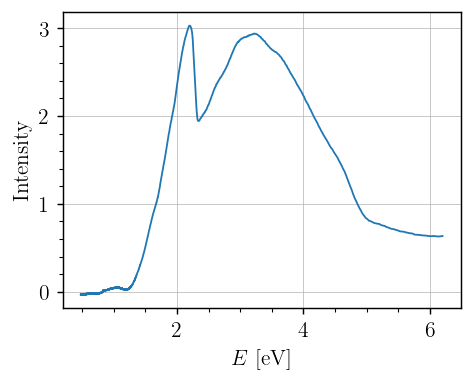

In [ ]:
photocurr1 = photocurrent_dataset[0]
plt.plot(photocurr1.E, photocurr1.intensity)
plt.xlabel("$E$ [eV]")
plt.ylabel("Intensity")

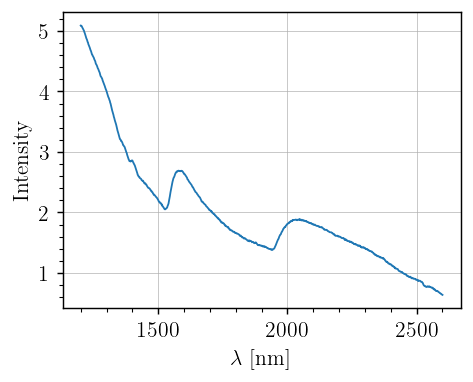

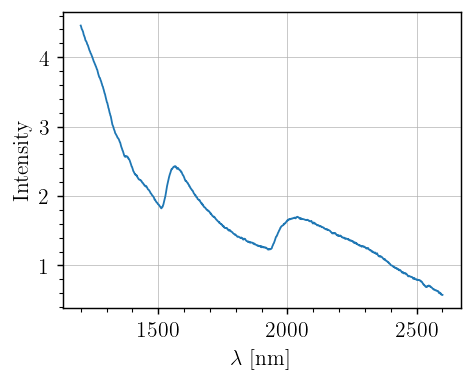

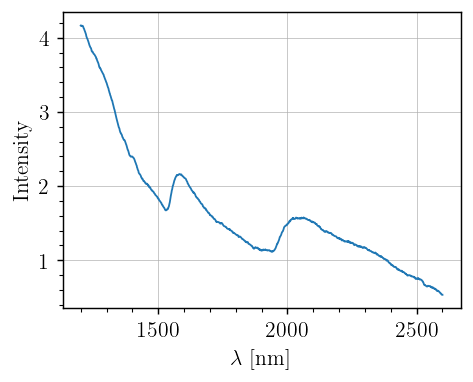

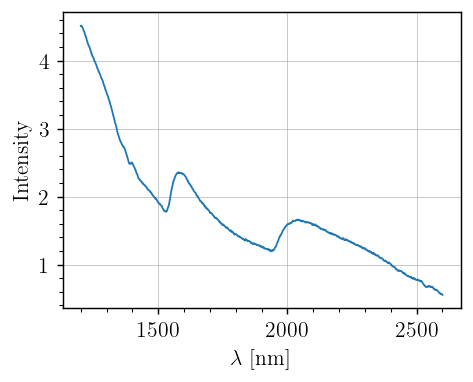

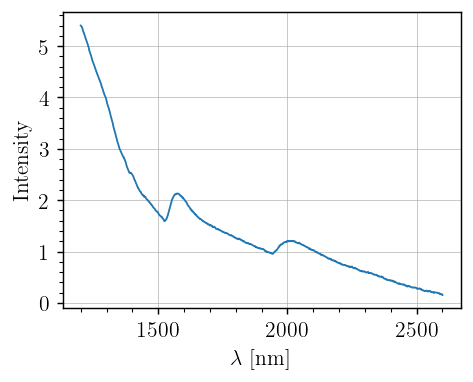

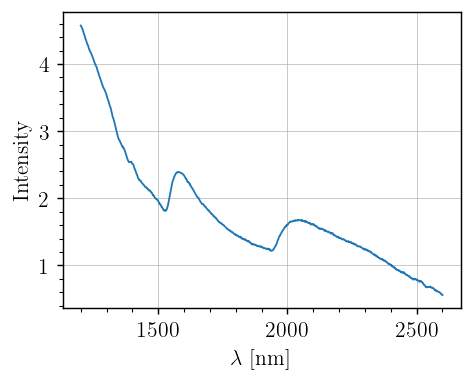

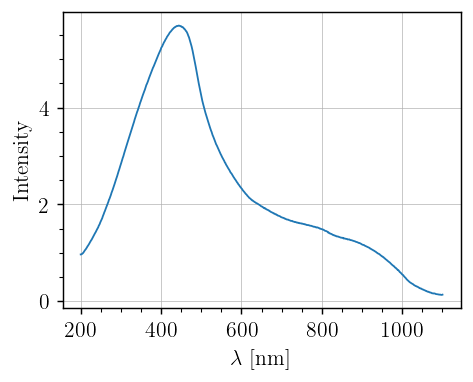

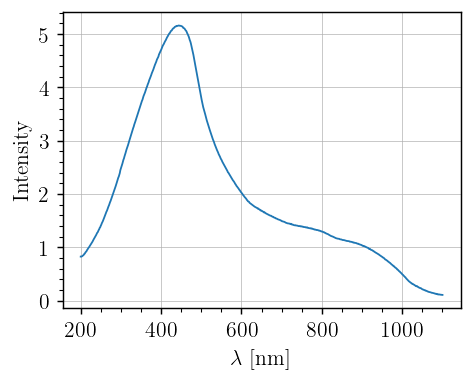

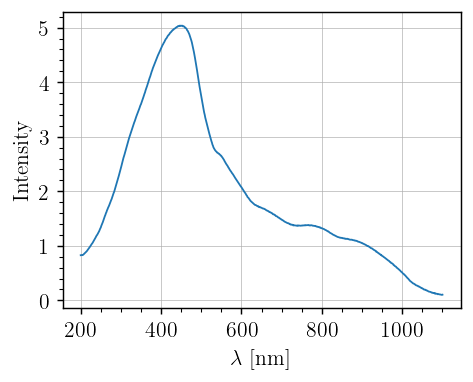

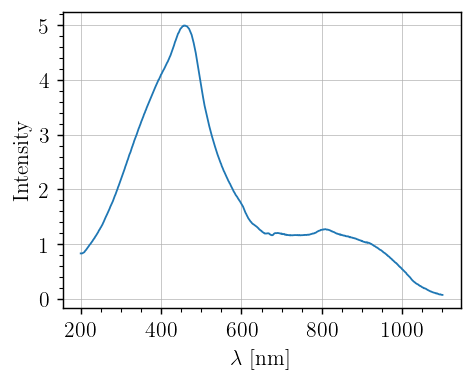

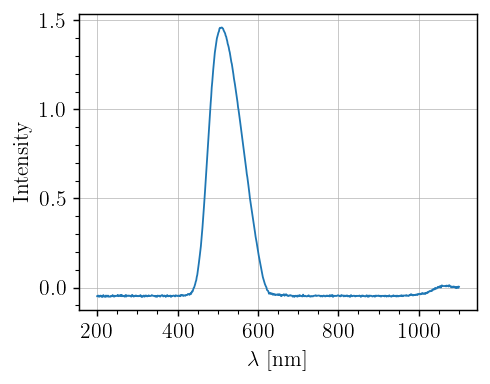

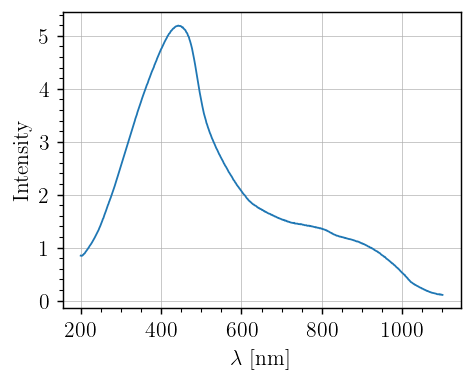

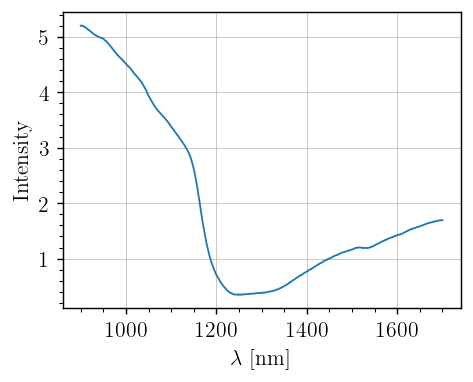

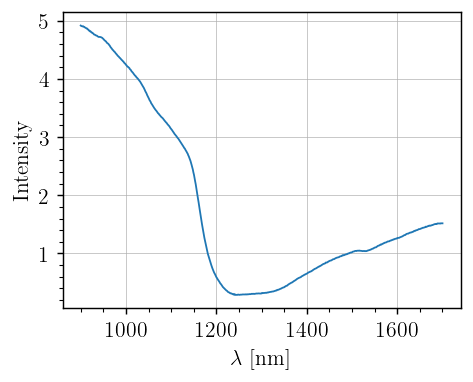

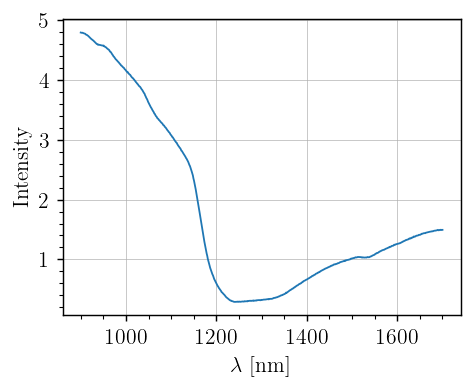

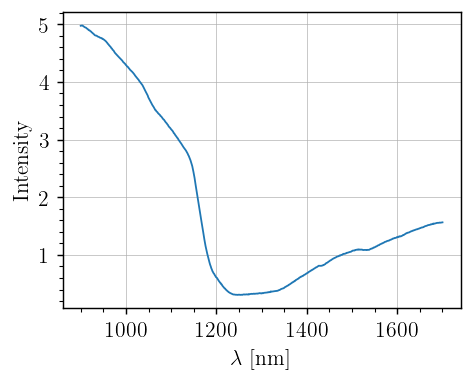

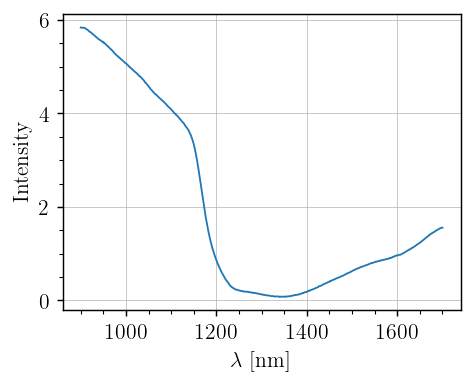

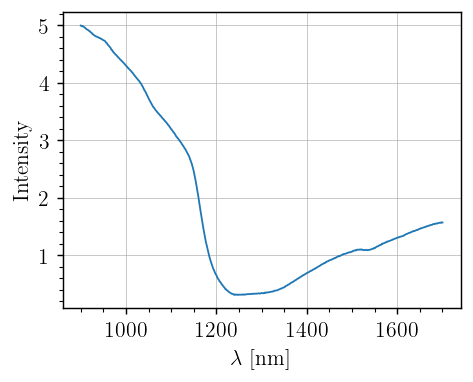

In [53]:
for data in calibration_dataset:
    plt.plot(data.lambd, data.intensity)
    plt.xlabel(r"$\lambda$ [nm]")
    plt.ylabel("Intensity")
    plt.show()

In [54]:
# data = dataset[6]
# print(np.histogram(data.intensity, np.arange(200, 1100, 10)))


[ 900  910  920  930  940  950  960  970  980  990 1000 1010 1020 1030
 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170
 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310
 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450
 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590
 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690] None


ValueError: x and y must be the same size

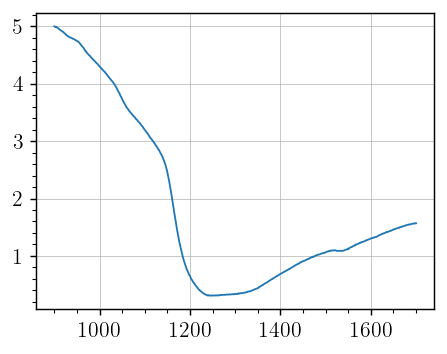

In [55]:
plt.plot(data.lambd, data.intensity)

bins, binned = binit(data.intensity, data.min_lambda, data.max_lambda, 10)
print(bins, binned)
plt.scatter(bins, binned)